In [28]:
import pandas as pd
from matplotlib import pyplot as plt
from tabulate import tabulate
import numpy as np
import re
import locale
locale.setlocale(locale.LC_ALL, '')
import sys
import subprocess
from scipy.optimize import minimize
from matplotlib import rcParams
from scipy.optimize import basinhopping
rcParams['figure.figsize'] = 9, 9

In [29]:
comps = pd.read_excel('tabulated_data3.xlsm', sheet_name='Compositions')
compNames = list(comps)[1:]
comps

Name McLeod-Mix1 McLeod-Mix2 McLeod-Mix3 McLeod-Mix22  \
0            Group      McLeod      McLeod      McLeod       McLeod   
1           Sample        Mix1        Mix2        Mix3        Mix22   
2               SG    0.705971    0.652476    0.609878     0.698439   
3    Inert Free SG    0.560051    0.558915    0.560063     0.681036   
4              CO2       0.005       0.003      0.0131        0.018   
..             ...         ...         ...         ...          ...   
111            NaN         NaN         NaN         NaN          NaN   
112            NaN         NaN         NaN         NaN          NaN   
113            NaN         NaN         NaN         NaN          NaN   
114            NaN         NaN         NaN         NaN          NaN   
115            NaN         NaN         NaN         NaN          NaN   

    McLeod-Mix24 McLeod-Mix25 Simon&Briggs-10PC Simon&Briggs-20PC API 37-Mix2  \
0         McLeod       McLeod      Simon&Briggs      Simon&Briggs      API 37   
1          Mix24        Mix25              10PC              20PC        Mix2   
2       0.741612      0.59657          0.616048          0.678315    0.789937   
3       0.736766     0.592865           0.55378           0.55378    0.718099   
4         0.0061        0.004                 0                 0      0.0209   
..           ...          ...               ...               ...         ...   
111          NaN          NaN               NaN               NaN         NaN   
112          NaN          NaN               NaN               NaN         NaN   
113          NaN          NaN               NaN               NaN         NaN   
114          NaN          NaN               NaN               NaN         NaN   
115          NaN          NaN               NaN               NaN         NaN   

     ... Dataset6-PantherRiver5-23#12 Dataset6-PantherRiver5-23#13  \
0    ...                     Dataset6                     Dataset6   
1    ...          PantherRiver5-23#12          PantherRiver5-23#13   
2    ...                     1.094394                     1.078121   
3    ...                       0.5585                     0.557337   
4    ...                       0.0796                       0.0874   
..   ...                          ...                          ...   
111  ...                          NaN                          NaN   
112  ...                          NaN                          NaN   
113  ...                          NaN                          NaN   
114  ...                          NaN                          NaN   
115  ...                          NaN                          NaN   

    Dataset6-PantherRiver5-23#14 Dataset6-PantherRiver5-23#15  \
0                       Dataset6                     Dataset6   
1            PantherRiver5-23#14          PantherRiver5-23#15   
2                       1.065133                      1.06303   
3                       0.556558                     0.556519   
4                         0.0914                       0.0912   
..                           ...                          ...   
111                          NaN                          NaN   
112                          NaN                          NaN   
113                          NaN                          NaN   
114                          NaN                          NaN   
115                          NaN                          NaN   

    Dataset6-PantherRiver5-23#16 Dataset6-JeffLake11-25-25-29  \
0                       Dataset6                     Dataset6   
1            PantherRiver5-23#16          JeffLake11-25-25-29   
2                       1.057508                     0.872642   
3                       0.557425                     0.563638   
4                         0.0914                       0.1016   
..                           ...                          ...   
111                          NaN                          NaN   
112                          NaN              

In [30]:
def make_valid_filename(input_string):
    valid_filename = re.sub(r'[^\w.-]', '_', input_string)
    valid_filename = valid_filename.strip()
    valid_filename = re.sub(r'[-_.]{2,}', '_', valid_filename)
    valid_filename = valid_filename.replace('@', '_').replace('#', '_')
    return valid_filename

filename ='Crit_props_7_curved'

In [31]:
R, mwAir, degF2R = 10.731577089016, 28.97, 459.67
class mix:
    def __init__(self, name, group, sample, sg, co2, h2s, n2, gas, coefic_pc, coefic_tc):
        self.comps = [co2, h2s, n2, gas]
        self.compnames = ['CO2', 'H2S', 'N2', 'Gas']
        self.name = make_valid_filename(name)
        self.group = group
        self.sample = sample
        self.sg = sg
        mws = np.array([44.01, 34.082, 28.014, 0])
        self.sg_hc = (sg - (co2 * mws[0] + h2s * mws[1] + n2 * mws[2]) / mwAir) / (1 - co2 - h2s - n2)
        mw_gas = self.sg_hc * mwAir
        #self.pc = (coefic_pc[0] * mw_gas + coefic_pc[1])/(coefic_pc[2] * mw_gas + coefic_pc[3])
        #self.tc = (coefic_tc[0] * mw_gas + coefic_tc[1] ) /(coefic_tc[2] * mw_gas + coefic_tc[3] )     
        self.pc = (coefic_pc[0] * mw_gas + coefic_pc[1])
        self.tc = (coefic_tc[0] * mw_gas + coefic_tc[1] )
        self.expmt = pd.read_excel('tabulated_data3.xlsm', sheet_name=name)
        
    def write_include(self, base_chr): # Write include files for 4 component model
        mws = np.array([44.01, 34.082, 28.014, 0])
        df = self.expmt.copy()
        temps = list(set(df['degf'].to_list()))
        temps.sort()
        
        out_str = 'DEFINE MW '+str(self.sg_hc * mwAir)+'\n'
        out_str += 'INCLUDE '+self.name+'_init.inc\n\n'
        
        if self.sg_hc * mwAir < 0:
            print(self.comps)
            print(self.name)
            print(self.sample)
            print(self.sg)
            print(self.sg_hc)
            print(self.sg, self.comps[0], mws[0], self.comps[1], mws[1], self.comps[2], mws[2], mwAir)
            stop
        
        for temp in temps:
            out_str += 'DEFINE degR '+str(temp+459.67)+'\n\n'
            out_str += 'CHARACTERIZATION "CHR_'+self.name+'_'+str(temp)+'" BASE "'+base_chr+'"\n'
            header = ['COMPONENT', 'MW', 'TC,R', 'PC,PSIA', 'AF', 'VTRAN', 'A', 'B']
            rows = []
            for c in range(len(self.compnames)):
                rows.append([self.compnames[c], '', '', '', '', '', '', ''])
            rows[-1][1] = round(self.sg_hc * 28.97, 2)
            rows[-1][2] = round(self.tc,2)
            rows[-1][3] = round(self.pc,2)

            out_str += tabulate(rows, header)
            out_str += '\nEND\n\n'
            
            out_str += 'DEFINE degR_Slope CO2_degR_Slope, DEFINE MW_Slope CO2_MW_Slope, DEFINE Intcpt CO2_Intcpt, DEFINE Inert CO2\n'
            out_str += 'INCLUDE bips_calc.inc\n\n'
            
            out_str += 'DEFINE degR_Slope H2S_degR_Slope, DEFINE MW_Slope H2S_MW_Slope, DEFINE Intcpt H2S_Intcpt, DEFINE Inert H2S\n'
            out_str += 'INCLUDE bips_calc.inc\n\n'
            
            out_str += 'DEFINE degR_Slope N2_degR_Slope, DEFINE MW_Slope N2_MW_Slope, DEFINE Intcpt N2_Intcpt, DEFINE Inert N2\n'
            out_str += 'INCLUDE bips_calc.inc\n\n'
            
            # Inert:Inert BIP Pairs                                                                                                   
            slopes = [[-0.000811631, -0.00112389, 0.001138791],                                
                      [0.000199936, 0.000648016, 0.001931865]]                                    
            intcpts = [[0.244400582, -0.1389305, 0.251688807],                                   
                       [0.084399052, -0.294767027, 0.079487455]]                               
            evals = [np.max, np.max, np.max]                                                                  
            pairs = ['H2S with CO2', 'CO2 with N2', 'H2S WITH N2']                       
            inert_bips = [evals[i]([slopes[0][i]*temp + intcpts[0][i], slopes[1][i]*temp + intcpts[1][i]]) for i in range(len(pairs))]
                                                                                                                                  
            for p, pair in enumerate(pairs):                                                                                          
                out_str += 'REPLACE BIP of '+pair+' by '+str(inert_bips[p])+'\n'                             
            
            out_str += '\nREPLACE TC of Gas by ?MW? R\n'
            out_str += 'MULTIPLY TC of Gas by TC_slope\n'
            out_str += 'INCREASE TC of Gas by TC_int R\n'
            out_str += 'MULTIPLY TC of Gas by ?mult_tc?\n\n' 
            
            out_str += 'REPLACE PC of Gas by ?MW? psia\n'
            out_str += 'MULTIPLY PC of Gas by PC_slope\n'
            out_str += 'INCREASE PC of Gas by PC_int psia\n\n'
            out_str += 'MULTIPLY PC of Gas by ?mult_pc?\n\n'
            
            
            out_str += 'MIX '+self.name+'_'+str(temp)+'\n'
            
            rows = []
            for c in range(len(self.compnames)):
                rows.append([self.compnames[c], self.comps[c]])
            out_str += tabulate(rows)
            out_str += '\nEND\n\n'
        
            out_str += 'QIX FEED 1 MOLE '+self.name+'_'+str(temp)+'\n'
            out_str += 'CCE ID "'+self.name+'_'+str(temp)+'"\n'

            exp_df = pd.DataFrame()
        
            filterd_df = df[df['degf'] == temp].copy()
            temps = filterd_df['degf'].to_list()+['Wt']
            press = filterd_df['psia'].to_list()+['']
            zs = filterd_df['Z'].to_list()+[1]
            gss = [1 for z in zs]
            gss[-1] = 0
            
            exp_df['TEMP (F)']= temps
            exp_df['PRES (psia)']= press
            exp_df['Z']= zs
            exp_df['GS']= gss

            out_str += tabulate(exp_df, headers='keys', showindex='never', numalign='left')
            out_str += '\nEND\n\n'

        return out_str


In [32]:
phz_template = filename+'.phz' # The .Phz file to use as the base
#phz_template = 'Inerts_PR_Match_VSHIFT_Only_AB_CO2_BigLoop_BIPS_Temp_reduced_MW_Slope3_Orig_Omega.phz' # The .Phz file to use as the base


#Phz_loc = "C:\\Temp\\PhazeComp\\phazecomp.exe"         # The location of the PhazeComp executable on your system
Phz_loc = "C:\\Program Files\\PhazeComp\\1.81\\phazecomp.exe"         # The location of the PhazeComp executable on your system

def create_phz(phz_template):
    rms=float("nan")
    try:
        proc = subprocess.run([Phz_loc, phz_template,'NUL',">"], capture_output=True)
    except:
        print("Either phazecomp.exe couldnt be found (is it in "+Phz_loc+" ?), or "+phz_template+" couldn't be found - Exiting..")
        sys.exit()
    
    found_rms = False
    for i in range(len(proc.stderr.splitlines())-1,0,-1):
        line = proc.stderr.splitlines()[i].decode("utf-8")
        if "% RMS average weighted" in line:
            rms = float(line.split()[2])
            found_rms = True
            break
    if not found_rms:
        print("Error: No RMS for ",phz_template)
    return rms

In [9]:
x = [0.000686956691, 1.69866602, 0.00126240593, 0.333600083]
x = [0.000746468, 1.313497747, 0.001116319, 0.353188266]
mw_hcs = [16.043, 25.977, 33.864, 45.08779652]                                                    
coefic_pc = x[:2]                                                                                 
coefic_tc = x[2:]                                                                                 
comp_dic = {}                                                                                     
#print(x)                                                                                         
for c in range(len(compNames)):                                                                   
    name = compNames[c]                                                                           
    group = comps.iloc[0, c+1]                                                                    
    sample = comps.iloc[1, c+1]                                                                   
    sg = comps.iloc[2, c+1]                                                                       
    co2 = comps.iloc[4, c+1]                                                                      
    h2s = comps.iloc[5, c+1]                                                                      
    n2 = comps.iloc[6, c+1]                                                                       
    gas = 1 - co2 - h2s - n2                                                                      
    comp_dic[name] = mix(name, group, sample, sg, co2, h2s, n2, gas, coefic_pc, coefic_tc)        
                                                                                                  
# 4 component include files                                                                       
for c in range(len(compNames)):                                                                   
    file_path = make_valid_filename(compNames[c])                                                 
    string = comp_dic[compNames[c]].write_include('RealGas')                                      
    with open('.\\'+filename+'\\'+file_path+'.inc', 'w') as file:                                 
        print('.\\'+filename+'\\'+file_path+'.inc')                                               
        file.write(string)                                                                        
                                                                                                  
#gergs = ['lean', 'leanmid', 'mid', 'rich']                                                       
#gerg_mws = [16.043, 25.977, 33.864, 45.08779652]                                                 
                                                                                                  
#for g, gerg in enumerate(gergs):                                                                 
#    out_str = 'DEFINE MW '+str(mw_hcs[g])+'\n'                                                   
#    out_str += 'DEFINE mult_tc '+str(1/(coefic_tc[0] * gerg_mws[g] + coefic_tc[1]) )+'\n'        
#    out_str += 'DEFINE mult_pc '+str(1/(coefic_pc[0] * gerg_mws[g] + coefic_pc[1]))+'\n'         
#    with open('.\\GERG\\'+gerg+'_init.inc', 'w') as file:                                        
#        file.write(out_str)                                                                      
                                                                                                  
#rms = create_phz(phz_template)                                                                   
#print(x, rms)                                                                                    
#return rms                                                                                       

.\Crit_props_7_curved\McLeod-Mix1.inc
.\Crit_props_7_curved\McLeod-Mix2.inc
.\Crit_props_7_curved\McLeod-Mix3.inc
.\Crit_props_7_curved\McLeod-Mix22.inc
.\Crit_props_7_curved\McLeod-Mix24.inc
.\Crit_props_7_curved\McLeod-Mix25.inc
.\Crit_props_7_curved\Simon_Briggs-10PC.inc
.\Crit_props_7_curved\Simon_Briggs-20PC.inc
.\Crit_props_7_curved\API_37-Mix2.inc
.\Crit_props_7_curved\API_37-Mix17.inc
.\Crit_props_7_curved\API_37-Mix25.inc
.\Crit_props_7_curved\API_37-Mix26.inc
.\Crit_props_7_curved\API_37-Mix402.inc
.\Crit_props_7_curved\API_37-Mix601.inc
.\Crit_props_7_curved\API_37-Mix705.inc
.\Crit_props_7_curved\API_37-Mix707.inc
.\Crit_props_7_curved\API_37-Mix722.inc
.\Crit_props_7_curved\API_37-Mix727.inc
.\Crit_props_7_curved\API_37-Mix729.inc
.\Crit_props_7_curved\API_37-Mix735.inc
.\Crit_props_7_curved\Satter_Campbell-MixA.inc
.\Crit_props_7_curved\Satter_Campbell-MixB.inc
.\Crit_props_7_curved\Satter_Campbell-MixC.inc
.\Crit_props_7_curved\Satter_Campbell-MixD.inc
.\Crit_props_7_cur

In [33]:
def fn2(x):
    x = denorm_solx(x, bounds)
    coefic_pc = x[:2]
    coefic_tc = x[2:]
    
    # 4 component include files
    for comp in compNames:
        file_path = make_valid_filename(comp)
        mw = comp_dic[comp].sg_hc * 28.97
        string = 'DEFINE mult_tc '+ str(1/(coefic_tc[0]*mw + coefic_tc[1]))+'\n'
        string += 'DEFINE mult_pc '+ str(1/(coefic_pc[0]*mw + coefic_pc[1]))+'\n'
        
        with open('.\\'+filename+'\\'+file_path+'_init.inc', 'w') as file:
            #print('.\\'+filename+'\\'+file_path+'_init.inc')
            file.write(string)
    
    gergs = ['lean', 'leanmid', 'mid', 'rich']
    gerg_mws = [16.043, 25.977, 33.864, 45.08779652]

    for g, gerg in enumerate(gergs):
        out_str = 'DEFINE mult_tc '+str(1/(coefic_tc[0] * gerg_mws[g] + coefic_tc[1]) )+'\n'        
        out_str += 'DEFINE mult_pc '+str(1/(coefic_pc[0] * gerg_mws[g] + coefic_pc[1]))+'\n'
        with open('.\\GERG-curved\\'+gerg+'_gas_init.inc', 'w') as file:
            file.write(out_str)
        
    rms = create_phz(phz_template)
    print(x, rms)
    return rms

In [11]:
fn2(x)

[0.000746468, 1.313497747, 0.001116319, 0.353188266] 0.9104


0.9104

In [34]:
def norm_x0(x, bounds):
    x0 = []
    for i, bound in enumerate(bounds):
        span = bound[1] - bound[0]
        x0.append((x[i] - bound[0])/span)
    return x0

def denorm_solx(x, bounds):
    x0 = []
    for i, bound in enumerate(bounds):
        span = bound[1] - bound[0]
        x0.append(x[i]*span + bound[0])
    return x0
    

In [25]:
norm_x0(x0, bounds)

[0.5052819275928572,
 0.38450160937500005,
 0.5086464887142857,
 0.16456958539205155]

In [21]:
denorm_solx([0.5052819275928572,
 0.38450160937500005,
 0.5086464887142857,
 0.16456958539205155], bounds)

[0.0007394698629999974, 1.42432412, 0.001210508420000006, 0.333321426]

In [39]:
#x0 = [-0.004289489, -4.521919227, 756.8, -0.08817282, 12.06420435, 169.2] # Base Sutton
# x0 = [-3.55897620e-03, -2.78434498e+00,  7.04262503e+02, -1.00841444e-01, 1.17914323e+01,  1.80343787e+02] # v3 previous best

#x0 = [-9.38491450e-01,  9.13571165e+02,  4.90854197e-03,  1.29146359e+00,  6.24106819e+00,  9.74288258e+00,  7.23867099e-03,  2.08134634e-01]
#x0 = [-2.23048,6.87323e+02,0,1,8.21344,2.12017e+02,0,1]
x0 = [0.00529424, 1.59103386, 0.00234167, 0.31144261]
x0 = [7.05821902e-04, 1.70270381e+00, 1.19687273e-03, 3.35493340e-01]

#x0 = [5.76161228e-03, 1.92000000e+00, -1.89318001e-04, 4.69900642e-01]
#bounds = [(min(x*0.5, x*1.5), max(x*0.5, x*1.5)) for x in x0]
#bounds = [(-3.3875000000000002, -0.4625), (400, 1375.5), (-0.07, 0.07), (0.44, 1.92),
# (3.110137083, 9.330411249), (4.7625179755, 300), (-0.07, 0.07), (0.1035, 1.5)]

x0 = [7.39469863e-04, 1.42432412e+00, 1.21050842e-03, 3.33321426e-01]
x0 = [0.007020498750000034, 1.5010786600000001, 0.0024482299999999957, 0.3219414605]
bounds = [(0, 0.02), (0.5, 3), (0, 0.01), (0.1, 0.6)]
x = norm_x0(x0, bounds)

sol = minimize(fn2, x, method='Nelder-Mead', bounds=[(0, 1), (0, 1), (0, 1), (0, 1)])


[0.007020498750000034, 1.5010786600000001, 0.0024482299999999957, 0.3219414605] 1.268
[0.007371523687500036, 1.5010786600000001, 0.0024482299999999957, 0.3219414605] 1.273
[0.007020498750000034, 1.5511325930000002, 0.0024482299999999957, 0.3219414605] 1.273
[0.007020498750000034, 1.5010786600000001, 0.0025706414999999956, 0.3219414605] 1.268
[0.007020498750000034, 1.5010786600000001, 0.0024482299999999957, 0.333038533525] 1.273
[0.007196011218750035, 1.5261056265000004, 0.0025094357499999952, 0.310844387475] 1.27
[0.007283767453125035, 1.4635382102500003, 0.002540038624999995, 0.31639292398749996] 1.273
[0.007086315925781283, 1.5292339973125002, 0.0024711821562499957, 0.320554326371875] 1.273
[0.007020498750000034, 1.5010786600000001, 0.0025094357499999952, 0.3219414605] 1.269
[0.007108254984375034, 1.5135921432500004, 0.0024788328749999955, 0.31639292398749996] 1.273
[0.007196011218750035, 1.5010786600000001, 0.0024482299999999957, 0.3219414605] 1.273
[0.007020498750000034, 1.52610562

In [17]:
x1 = [0.000686956691, 1.69866602, 0.00126240593, 0.333600083]
x2 = [0.000746468, 1.313497747, 0.001116319, 0.353188266]
x3 = [0.00514195, 1.50107866, 0.00244823, 0.30153678]
fn2(x1)
fn2(x2)
fn2(x3)

[0.000686956691, 1.69866602, 0.00126240593, 0.333600083] 1.284
[0.000746468, 1.313497747, 0.001116319, 0.353188266] 1.286
[0.00514195, 1.50107866, 0.00244823, 0.30153678] 1.281


1.281

In [41]:
# Run once at the end to ensure the directory of experiments reflects the solution case
fn2(sol.x)

[0.007020498750000034, 1.5010786600000001, 0.0024482299999999957, 0.3219414605] 1.268


1.268

In [50]:
class solx:
    def __init__(self, x = [-3.78682503e-03, -2.78038939e+00,  7.03816710e+02, -9.85100535e-02, 1.17919736e+01,  1.79590669e+02]):
        self.x = x
        
sol = solx([-4.41997873e-03, -4.66832229e+00,  7.36742274e+02, -8.82275084e-02,   1.18700954e+01,  1.74473903e+02])

#sol = solx([-3.70657281e-03, -2.73168017e+00,  7.20789898e+02, -9.61269964e-02, 1.18647207e+01,  1.81862000e+02])


## Contrast custom critical properties with Sutton properties

In [52]:
def sutton(sg_hc):
    ppc_hc = 756.8 - 131.0 * sg_hc - 3.6 * sg_hc ** 2  # Eq 3.47b
    tpc_hc = 169.2 + 349.5 * sg_hc - 74.0 * sg_hc ** 2  # Eq 3.47a
    return (tpc_hc, ppc_hc)

# Modified Sutton Tc and Pc
def tc_pc(sg_hc):
    coefic_pc = sol.x[:3]
    coefic_tc = sol.x[3:]
    mw_gas = mwAir * sg_hc
    ppc_hc = coefic_pc[0] * mw_gas ** 2 + coefic_pc[1] * mw_gas + coefic_pc[2]
    tpc_hc = coefic_tc[0] * mw_gas ** 2 + coefic_tc[1] * mw_gas + coefic_tc[2] 
    return (tpc_hc, ppc_hc)
    

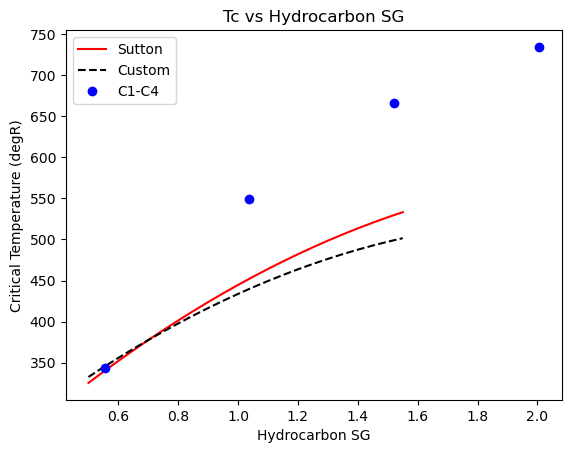

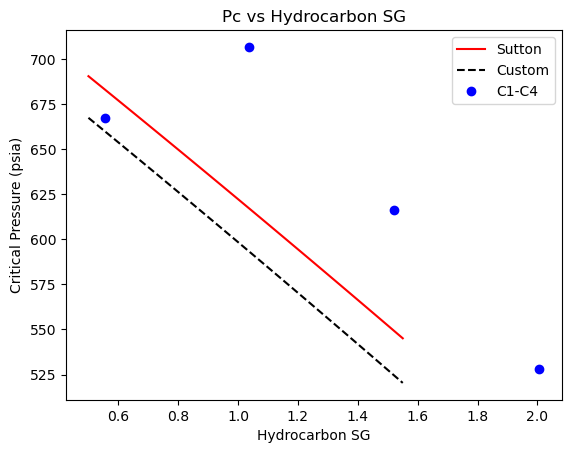

In [60]:
tc, pc = [[], []], [[], []]

sgs = np.arange(0.5, 1.6, 0.05)
for sg in sgs:
    sut_tc, sut_pc = sutton(sg)
    cust_tc, cust_pc = tc_pc(sg)
    tc[0].append(sut_tc)
    tc[1].append(cust_tc)
    pc[0].append(sut_pc)
    pc[1].append(cust_pc)

tc_scn = np.array([343.0080, 549.5760, 665.6940, 734.1300])
pc_scn = np.array([667.029, 706.624, 616.120, 527.937])
sg_scn = np.array([16.043, 30.070, 44.097, 58.123])/28.97

plt.plot(sgs, tc[0], '-', c='r', label='Sutton')
plt.plot(sgs, tc[1], '--', c='k', label='Custom')
plt.plot(sg_scn, tc_scn, 'o', c='b', label='C1-C4')
plt.title('Tc vs Hydrocarbon SG')
plt.xlabel('Hydrocarbon SG')
plt.ylabel('Critical Temperature (degR)')
plt.legend()
plt.savefig('tc.png')
plt.show()

plt.plot(sgs, pc[0], '-', c='r', label='Sutton')
plt.plot(sgs, pc[1], '--', c='k', label='Custom')
plt.plot(sg_scn, pc_scn, 'o', c='b', label='C1-C4')
plt.xlabel('Hydrocarbon SG')
plt.ylabel('Critical Pressure (psia)')
plt.title('Pc vs Hydrocarbon SG')
plt.legend()
plt.savefig('pc.png')
plt.show()

In [12]:
import pr_z_v4 as pr_eos
import importlib
importlib.reload(pr_eos)
import pyrestoolbox as rtb

In [13]:
df = pd.read_excel('Wichert_data_export.xlsx')
z_wichert = np.array(df['Z'])
degfs = np.array(df['degf'])
psias = np.array(df['psia'])
sgs = np.array(df['sg'])
co2s = np.array(df['co2'])
h2ss = np.array(df['h2s'])
n2s = np.array(df['n2'])
vol_wichert = R*(degfs + degF2R )*z_wichert/psias

#hc_mws = mwAir * (sgs - (co2s * 44.01 + h2ss * 34.082 + n2s * 28.014) / mwAir) / (1 - co2s - h2ss - n2s)

z_pr = np.array([pr_eos.peng_robinson_z(degfs[i], psias[i], sgs[i], co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i]) for i in range(len(degfs))])
vol_eos = R*(degfs + degF2R )*z_pr/psias
errs = np.abs(1 - z_pr / z_wichert)/z_wichert
np.where(errs > 0.05)

(array([ 99, 119, 120, 312, 717, 952, 954, 955], dtype=int64),)

In [14]:
z_dak_pmc = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='PMC', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])
z_dak_sut = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='SUT', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])

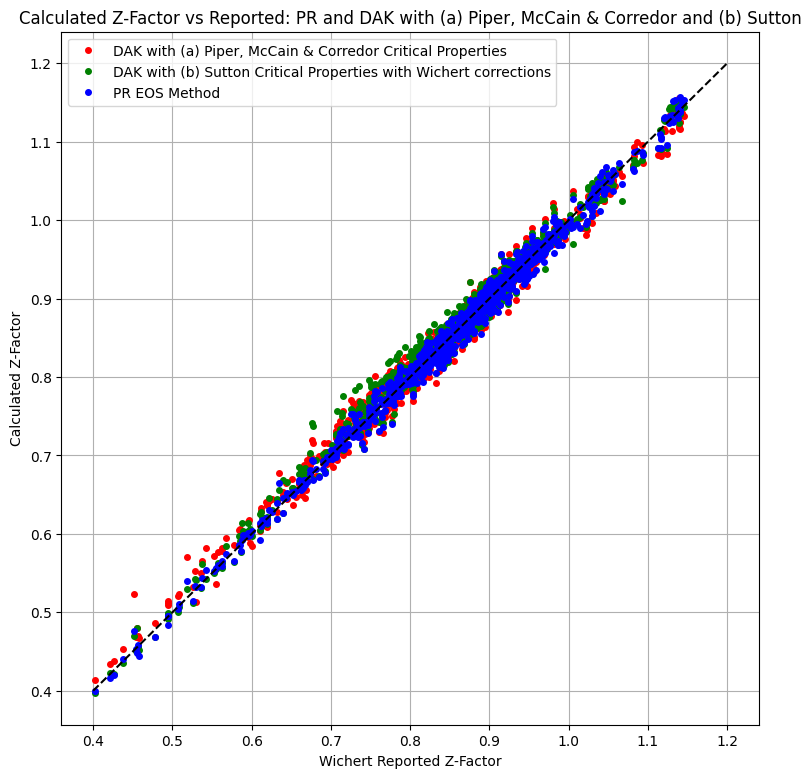

In [24]:

plt.plot(z_wichert, z_dak_pmc, 'o', c='r', markersize=4, label='DAK with (a) Piper, McCain & Corredor Critical Properties')
plt.plot(z_wichert, z_dak_sut, 'o', c='g', markersize=4, label='DAK with (b) Sutton Critical Properties with Wichert corrections')
plt.plot(z_wichert, z_pr, 'o', c='b', markersize=4, label='PR EOS Method')
plt.xlabel('Wichert Reported Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Calculated Z-Factor vs Reported: PR and DAK with (a) Piper, McCain & Corredor and (b) Sutton')
plt.legend(loc='upper left')
plt.savefig('Crossplot_Z-PR_DAK.png')
plt.show()

In [19]:
pr_er = (z_pr - z_wichert)/z_wichert
dak_sut_err = (z_dak_sut - z_wichert)/z_wichert
dak_pmc_err = (z_dak_pmc - z_wichert)/z_wichert

errs = [pr_er, dak_sut_err, dak_pmc_err]
names = ['Peng Robinson', 'DAK + Sutton & Wichert', 'DAK + PMC']
for e, err in enumerate(errs):
    avg = np.mean(err)
    maxerr = max(err)
    print(names[e], 'Avg Rel. Error: '+str(round(avg, 3))+', Max rel. Error: '+str(round(maxerr, 3))+', 95% Errors less than ', str(round(np.percentile(err, 95),4)))

Peng Robinson Avg Rel. Error: -0.001, Max rel. Error: 0.052, 95% Errors less than  0.0205
DAK + Sutton & Wichert Avg Rel. Error: 0.007, Max rel. Error: 0.097, 95% Errors less than  0.0336
DAK + PMC Avg Rel. Error: 0.004, Max rel. Error: 0.157, 95% Errors less than  0.0349


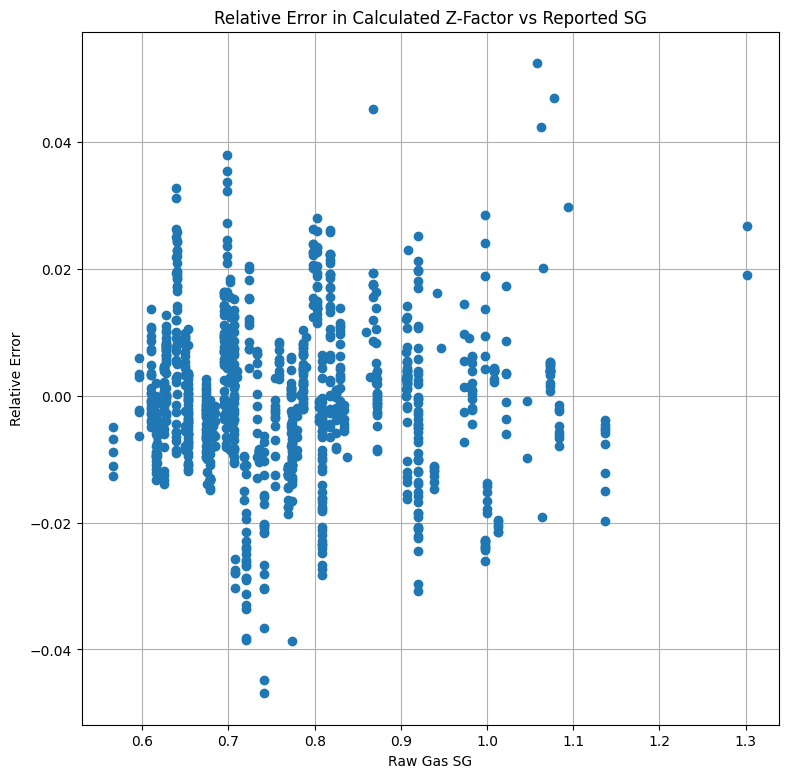

In [65]:
plt.plot(sgs, pr_er, 'o')
plt.xlabel('Raw Gas SG')
plt.ylabel('Relative Error')
#plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Relative Error in Calculated Z-Factor vs Reported SG')
#plt.legend()
plt.show()

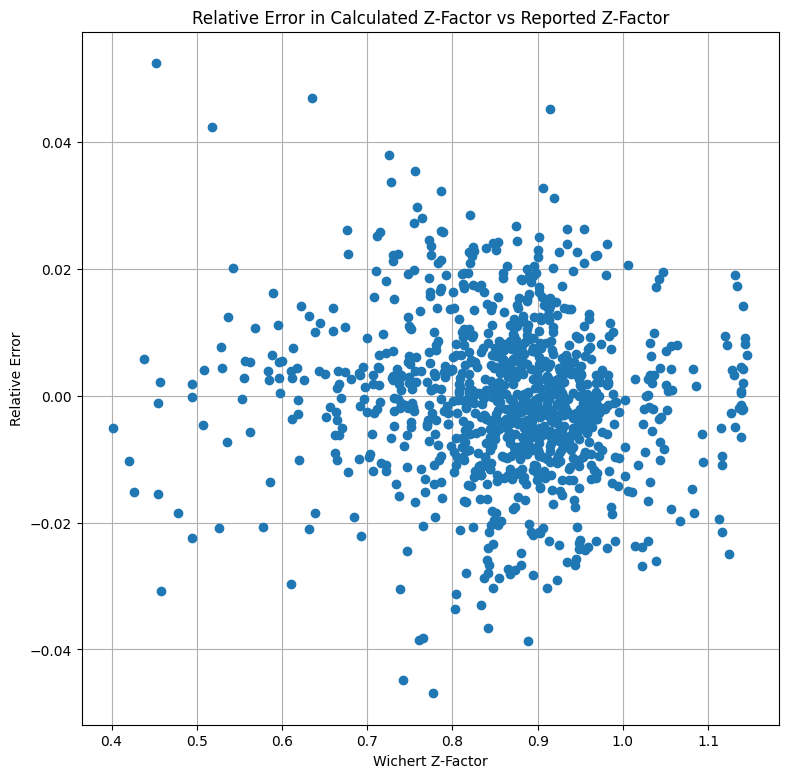

In [66]:
plt.plot(z_wichert, pr_er, 'o')
plt.xlabel('Wichert Z-Factor')
plt.ylabel('Relative Error')
#plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Relative Error in Calculated Z-Factor vs Reported Z-Factor')
#plt.legend()
plt.show()

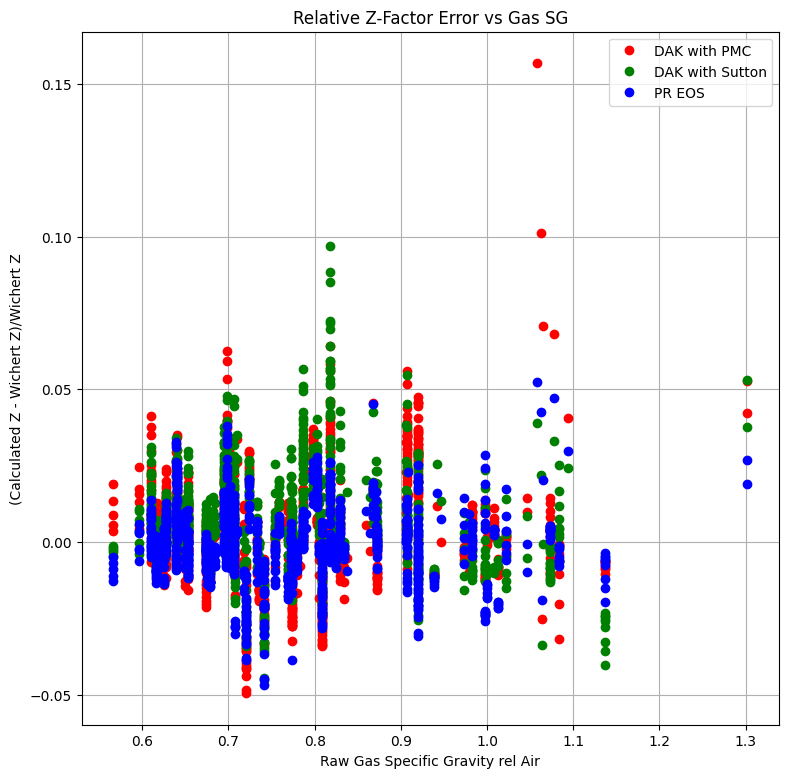

In [25]:
plt.plot(sgs, dak_pmc_err, 'o', c='r', label='DAK with PMC')
plt.plot(sgs, dak_sut_err, 'o', c='g', label='DAK with Sutton')
plt.plot(sgs, pr_er, 'o', c='b', label='PR EOS')

plt.xlabel('Raw Gas Specific Gravity rel Air')
plt.ylabel('(Calculated Z - Wichert Z)/Wichert Z')
#plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Relative Z-Factor Error vs Gas SG')
plt.legend()
plt.show()

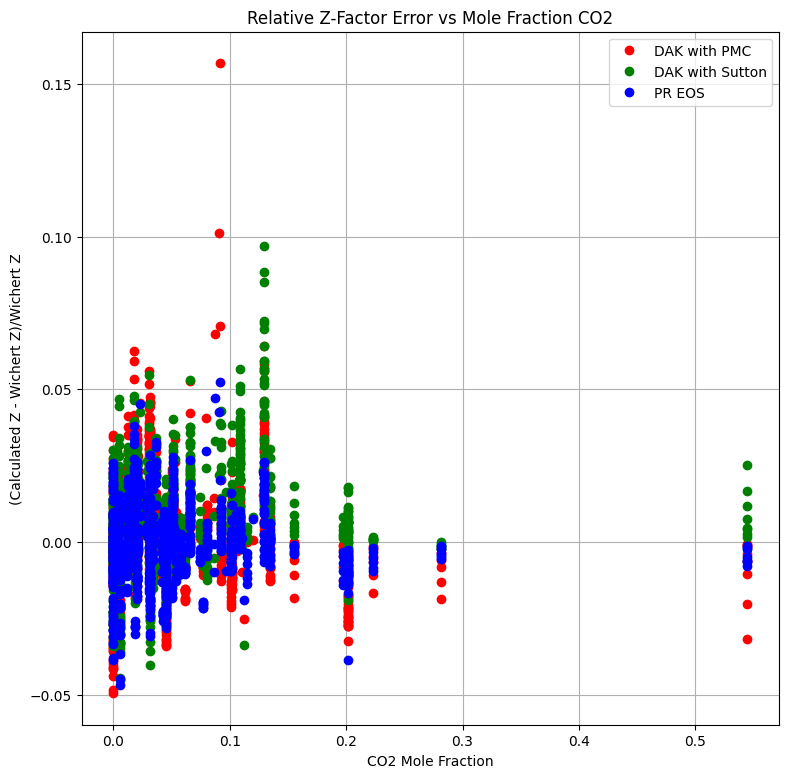

In [26]:
plt.plot(co2s, dak_pmc_err, 'o', c='r', label='DAK with PMC')
plt.plot(co2s, dak_sut_err, 'o', c='g', label='DAK with Sutton')
plt.plot(co2s, pr_er, 'o', c='b', label='PR EOS')

plt.xlabel('CO2 Mole Fraction')
plt.ylabel('(Calculated Z - Wichert Z)/Wichert Z')
#plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Relative Z-Factor Error vs Mole Fraction CO2')
plt.legend()
plt.show()

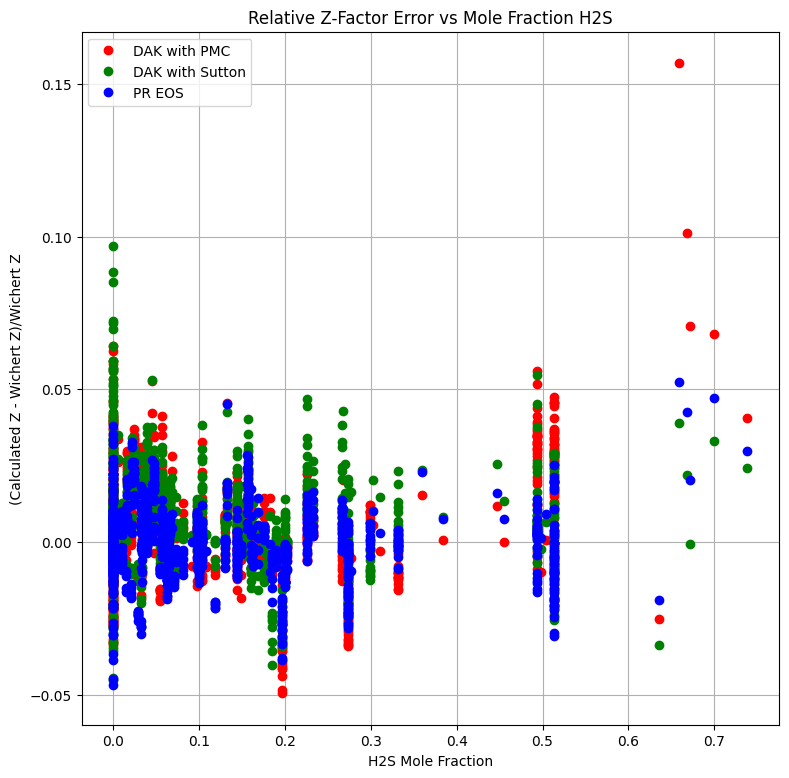

In [27]:
plt.plot(h2ss, dak_pmc_err, 'o', c='r', label='DAK with PMC')
plt.plot(h2ss, dak_sut_err, 'o', c='g', label='DAK with Sutton')
plt.plot(h2ss, pr_er, 'o', c='b', label='PR EOS')

plt.xlabel('H2S Mole Fraction')
plt.ylabel('(Calculated Z - Wichert Z)/Wichert Z')
#plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Relative Z-Factor Error vs Mole Fraction H2S')
plt.legend()
plt.show()

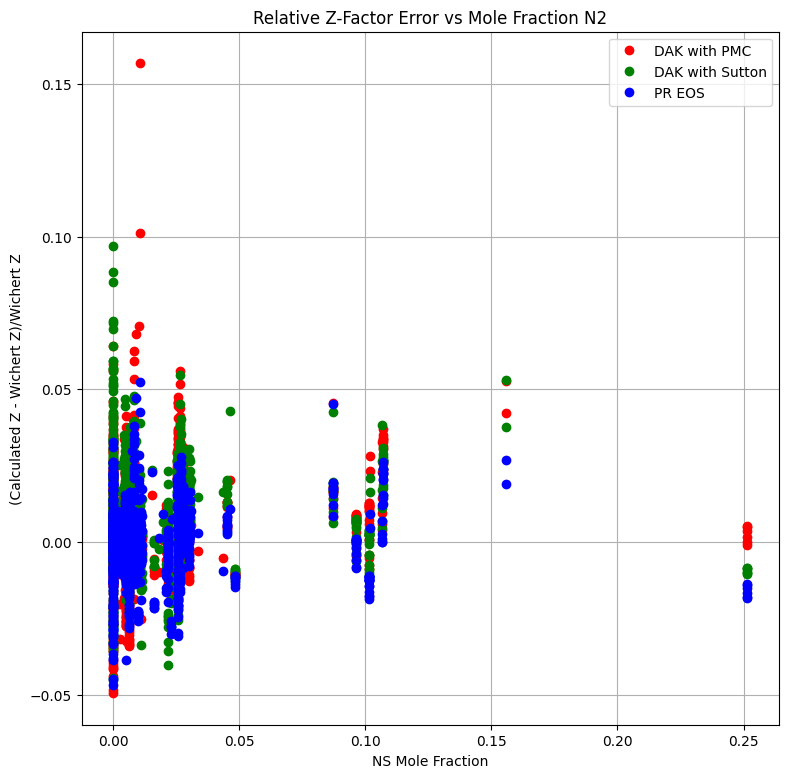

In [28]:
plt.plot(n2s, dak_pmc_err, 'o', c='r', label='DAK with PMC')
plt.plot(n2s, dak_sut_err, 'o', c='g', label='DAK with Sutton')
plt.plot(n2s, pr_er, 'o', c='b', label='PR EOS')

plt.xlabel('NS Mole Fraction')
plt.ylabel('(Calculated Z - Wichert Z)/Wichert Z')
#plt.plot([0.4, 1.2], [0.4, 1.2], '--', c='k')
plt.grid()
plt.title('Relative Z-Factor Error vs Mole Fraction N2')
plt.legend()
plt.show()

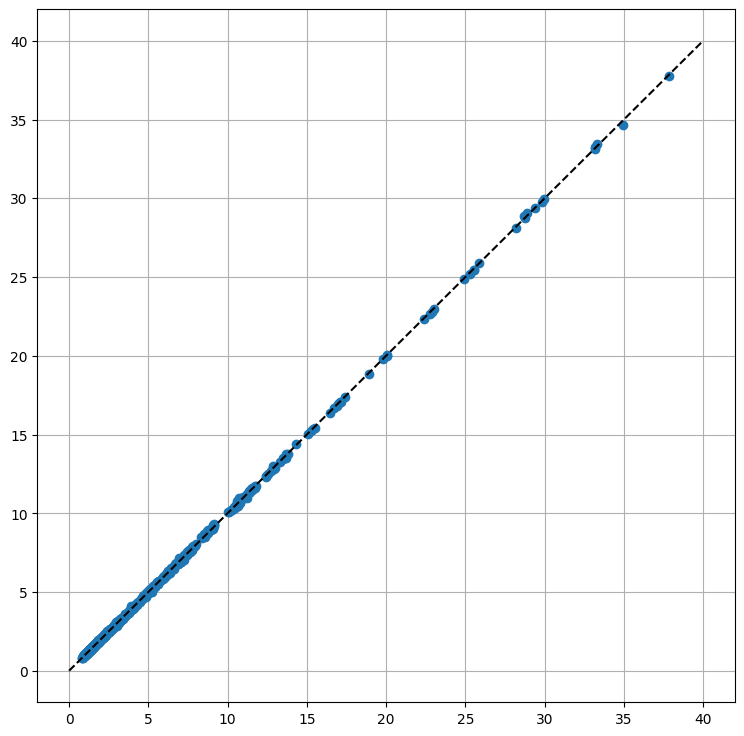

In [71]:
plt.plot(vol_wichert, vol_eos, 'o')
plt.plot([0, 40], [0, 40], '--', c='k')
plt.grid()
plt.show()